In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


sns.set_style("whitegrid")

In [2]:
species = pd.read_csv('species_info.csv')
observations = pd.read_csv('observations.csv')

species.head()
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [3]:
species.info()
species['conservation_status'] = species['conservation_status'].fillna('No Intervention')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


In [4]:
print(species['category'].value_counts())
print(species['conservation_status'].value_counts())

category
Vascular Plant       4470
Bird                  521
Nonvascular Plant     333
Mammal                214
Fish                  127
Amphibian              80
Reptile                79
Name: count, dtype: int64
conservation_status
No Intervention       5633
Species of Concern     161
Endangered              16
Threatened              10
In Recovery              4
Name: count, dtype: int64


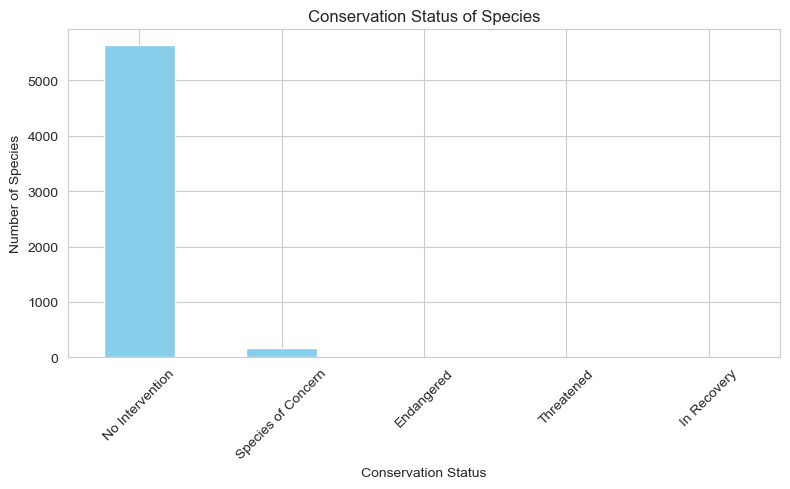

In [5]:
status_counts = species['conservation_status'].value_counts()

plt.figure(figsize=(8,5))
status_counts.plot(kind='bar', color='skyblue')
plt.title('Conservation Status of Species')
plt.xlabel('Conservation Status')
plt.ylabel('Number of Species')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
species['is_protected'] = species['conservation_status'] != 'No Intervention'

category_counts = species.groupby(['category', 'is_protected'])['scientific_name'].nunique().reset_index()
category_pivot = category_counts.pivot(index='category', columns='is_protected', values='scientific_name').reset_index()
category_pivot.columns = ['category', 'not_protected', 'protected']
category_pivot['percent_protected'] = category_pivot['protected'] / (category_pivot['protected'] + category_pivot['not_protected'])

category_pivot

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,0.088608
1,Bird,413,75,0.153689
2,Fish,115,11,0.087302
3,Mammal,146,30,0.170455
4,Nonvascular Plant,328,5,0.015015
5,Reptile,73,5,0.064103
6,Vascular Plant,4216,46,0.010793


In [7]:
merged = pd.merge(species, observations, on='scientific_name')
merged.head()

,category,scientific_name,common_names,conservation_status,is_protected,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,Bryce National Park,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,Yellowstone National Park,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,Great Smoky Mountains National Park,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,Yosemite National Park,117
4,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,Yosemite National Park,128


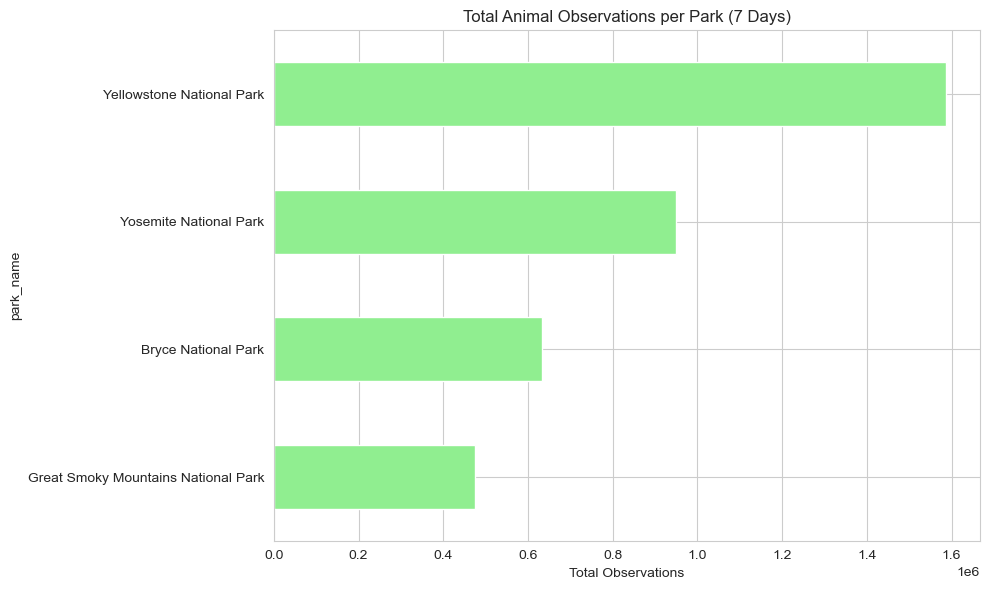

In [8]:
obs_by_park = merged.groupby('park_name')['observations'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
obs_by_park.plot(kind='barh', color='lightgreen')
plt.title('Total Animal Observations per Park (7 Days)')
plt.xlabel('Total Observations')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
top_species = merged.groupby(['park_name', 'common_names'])['observations'].sum().reset_index()
top_species_sorted = top_species.sort_values(by='observations', ascending=False)
top_species_sorted.head(10)


,park_name,common_names,observations
12737,Yellowstone National Park,Dicranum Moss,1779
11779,Yellowstone National Park,Brachythecium Moss,1673
15661,Yellowstone National Park,Sphagnum,1535
14672,Yellowstone National Park,Panic Grass,1524
11909,Yellowstone National Park,Bryum Moss,1474
13676,Yellowstone National Park,Hygrohypnum Moss,1287
13680,Yellowstone National Park,Hypnum Moss,1202
17283,Yosemite National Park,Brachythecium Moss,1066
14293,Yellowstone National Park,Mountain Lion,1037
14753,Yellowstone National Park,Philonotis Moss,1032


In [13]:
for park in merged['park_name'].unique():
    top5 = top_species[top_species['park_name'] == park].sort_values(by='observations', ascending=False).head(5)
    print(f"\nTop 5 observed species in {park}:")
    print(top5[['common_names', 'observations']])


Top 5 observed species in Bryce National Park:
            common_names  observations
1729       Dicranum Moss           707
771   Brachythecium Moss           672
901           Bryum Moss           637
3664         Panic Grass           619
4653            Sphagnum           547

Top 5 observed species in Yellowstone National Park:
             common_names  observations
12737       Dicranum Moss          1779
11779  Brachythecium Moss          1673
15661            Sphagnum          1535
14672         Panic Grass          1524
11909          Bryum Moss          1474

Top 5 observed species in Great Smoky Mountains National Park:
             common_names  observations
7233        Dicranum Moss           544
6275   Brachythecium Moss           499
9168          Panic Grass           489
6405           Bryum Moss           469
10157            Sphagnum           434

Top 5 observed species in Yosemite National Park:
             common_names  observations
17283  Brachythecium Moss    

In [15]:
contingency = [[category_pivot.loc[category_pivot['category'] == 'Mammal', 'protected'].values[0],
                category_pivot.loc[category_pivot['category'] == 'Mammal', 'not_protected'].values[0]],
               [category_pivot.loc[category_pivot['category'] == 'Bird', 'protected'].values[0],
                category_pivot.loc[category_pivot['category'] == 'Bird', 'not_protected'].values[0]]]

chi2, pval, dof, expected = chi2_contingency(contingency)
print(f"Chi-squared test p-value (Mammal vs Bird): {pval}")

Chi-squared test p-value (Mammal vs Bird): 0.6875948096661336
